In [1]:
import os
MAGNIFICATION_FACTOR = os.environ['MAGNIFICATION_FACTOR']
NUM_RUN = '1'
print((MAGNIFICATION_FACTOR, NUM_RUN))

('200X', '1')


In [2]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [3]:
layer_name = 'block4_pool'
feature_ex_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output, name='vgg16_features')
feature_ex_model.trainable = False
feature_ex_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [4]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

p1_layer = Lambda(vgg_preprocess, name='VGG_Preprocess')

image_input = Input((224, 224, 3), name='Image_Input')
p1_tensor = p1_layer(image_input)

out =feature_ex_model(p1_tensor)
feature_ex_model = Model(inputs=image_input, outputs=out)

In [5]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate
def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate()([conv1, conv3, conv5, pool])
    return layer_out

In [6]:
out = naive_inception_module(feature_ex_model.output, 64, 128, 32)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten
num_classes = 2

bn1 = BatchNormalization(name='BN')(out)

f = Flatten()(bn1)
dropout = Dropout(0.4, name='Dropout')(f)
desne = Dense(num_classes, activation='softmax', name='Predictions')(dropout)

In [8]:
new_model = Model(inputs=feature_ex_model.input, outputs=desne)
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [9]:
from tensorflow import keras
opt = keras.optimizers.Adam(lr=0.001)

In [10]:
new_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [11]:
name = 'VGGINetWODA/%s' % MAGNIFICATION_FACTOR
path = './%s/%s' % (name, NUM_RUN)
!mkdir -p {path}

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [
    # ModelCheckpoint(monitor='val_accuracy',filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True)
]

In [13]:
from tensorflow.keras.callbacks import TensorBoard
callbacks += [TensorBoard(name + '/tensorboard-logs/' + NUM_RUN)]

In [14]:
import tensorflow as tf

image_size = (224, 224)
crop_size = (224, 224)
batch_size = 128

train_path = '../../Splitted_' + MAGNIFICATION_FACTOR + '/train'
val_path = '../../Splitted_' + MAGNIFICATION_FACTOR + '/val'
test_path = '../../Splitted_' + MAGNIFICATION_FACTOR + '/test'

def dataset(ds_path, image_size, crop_size, batch_size, train):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels
    
    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=train)
        return cropped_images, labels
    
#     # NO DATA AUGMENTATION WILL BE USED FOR THIS EXPERIMENT!
#     if train:
#         ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
#     ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_ds = dataset(train_path, image_size, crop_size, batch_size, train=True)
val_ds = dataset(val_path, image_size, crop_size, batch_size, train=False)
test_ds = dataset(test_path, image_size, crop_size, batch_size, train=False)

Found 1087 files belonging to 2 classes.
Found 181 files belonging to 2 classes.
Found 545 files belonging to 2 classes.


In [15]:
epochs=100
train_history = new_model.fit(train_ds, epochs=epochs, 
                              validation_data=val_ds,
                              verbose=1, callbacks=callbacks)

Epoch 1/100
1/9 [==>...........................] - ETA: 0s - loss: 1.1427 - accuracy: 0.5547WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
9/9 [==============================] - 41s 5s/step - loss: 3.1436 - accuracy: 0.7755 - val_loss: 8.7506 - val_accuracy: 0.8674
Epoch 2/100
9/9 [==============================] - 10s 1s/step - loss: 1.2135 - accuracy: 0.9282 - val_loss: 27.3805 - val_accuracy: 0.7348
Epoch 3/100
9/9 [==============================] - 10s 1s/step - loss: 0.3473 - accuracy: 0.9641 - val_loss: 20.2649 - val_accuracy: 0.7514
Epoch 4/100
9/9 [==============================] - 10s 1s/step - loss: 0.1589 - accuracy: 0.9770 - val_loss: 15.2444 - val_accuracy: 0.7680
Epoch 5/100
9/9 [==============================] - 10s 1s/step - loss: 0.0285 - acc

In [16]:
new_model.save_weights(path + '/model.h5')

In [17]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

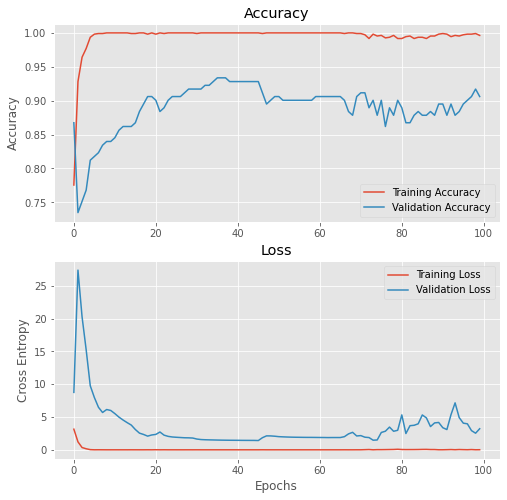

In [18]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot.pdf")
plt.show()

In [19]:
new_model.evaluate(test_ds)

5/5 [==============================] - 17s 3s/step - loss: 3.6443 - accuracy: 0.9156


[3.644345998764038, 0.9155963063240051]

In [20]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = new_model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
y_probas = y_pred
y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
print('Accuracy: ', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy:  0.9155963302752294
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       158
           1       0.93      0.96      0.94       387

    accuracy                           0.92       545
   macro avg       0.91      0.88      0.89       545
weighted avg       0.91      0.92      0.91       545



In [21]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

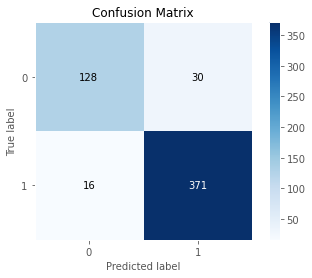

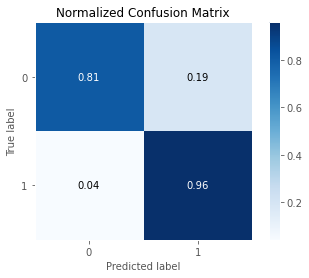

In [22]:
plot_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, normalize=True)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

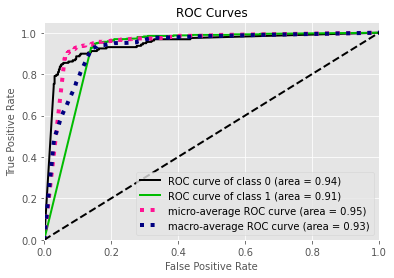

In [23]:
plot_roc(y_true, y_probas)

In [24]:
from imblearn.metrics import classification_report_imbalanced

In [25]:
print(classification_report(y_true, y_pred))
print(classification_report_imbalanced(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85       158
           1       0.93      0.96      0.94       387

    accuracy                           0.92       545
   macro avg       0.91      0.88      0.89       545
weighted avg       0.91      0.92      0.91       545

                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.81      0.96      0.85      0.88      0.77       158
          1       0.93      0.96      0.81      0.94      0.88      0.79       387

avg / total       0.91      0.92      0.85      0.91      0.88      0.78       545

